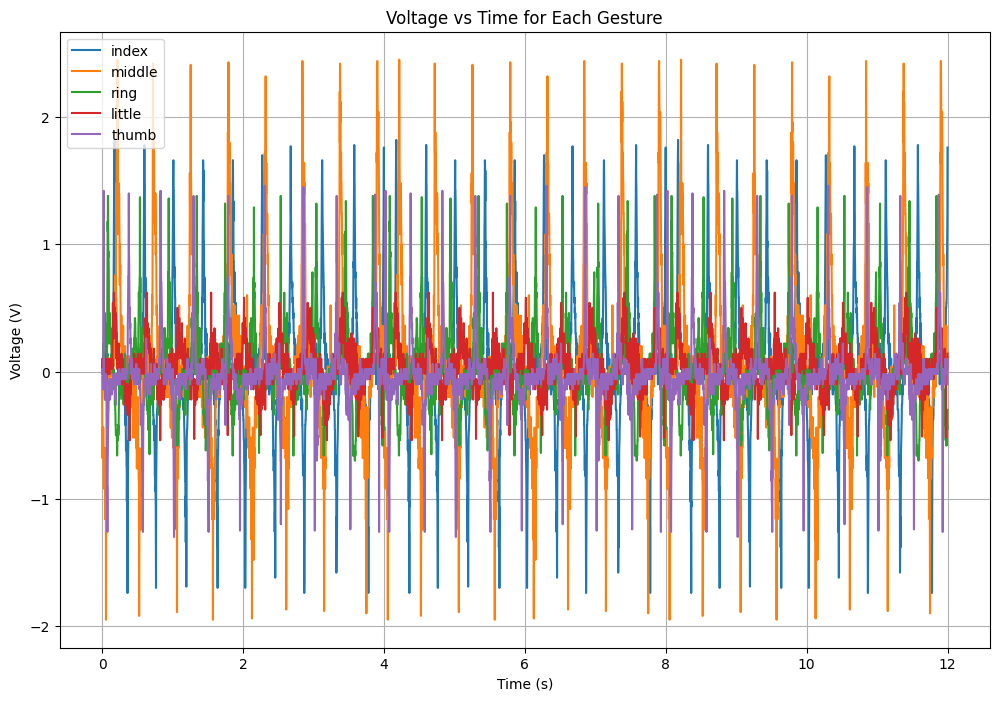

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file, skipping the first two rows
file_path = '/content/new_different_finger.xlsx'  # Replace with the actual file path
data = pd.read_excel(file_path, header=None)

# Map gestures to their respective columns and the subtraction value for time
gesture_columns = {
    "index": (0, 1, 0),   
    "middle": (2, 3, 0),   
    "ring": (4, 5, 0),   
    "little": (6, 7, 0),    
    "thumb": (8, 9, 0)    
}

# Initialize a dictionary to store gesture data
data_dict = {}

# Process each gesture
for gesture, (time_col, voltage_col, subtract_value) in gesture_columns.items():
    # Extract Time and Voltage for the gesture
    time = pd.to_numeric(data[time_col], errors='coerce') - subtract_value  # Apply subtraction to time
    voltage = pd.to_numeric(data[voltage_col], errors='coerce')

    # Store in the dictionary
    data_dict[gesture] = {
        "time": time,
        "voltage": voltage
    }

# Plot Voltage vs Time for each gesture
plt.figure(figsize=(12, 8))
for gesture, values in data_dict.items():
    plt.plot(values["time"], values["voltage"], label=gesture)

plt.title("Voltage vs Time for Each Gesture")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import random

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 2: Prepare Sequences for Model Training
all_sequences, all_labels = [], []
time_steps = 1000  # Length of each sequence

scaler = MinMaxScaler()
label_mapping = {gesture: idx for idx, gesture in enumerate(gesture_columns.keys())}

for gesture, values in data_dict.items():
    time = values["time"].dropna().values
    voltage = values["voltage"].dropna().values.reshape(-1, 1)

    # Normalize voltage values
    #voltage = scaler.fit_transform(voltage)

    # Prepare sequences
    for i in range(len(voltage) - time_steps):
        sequence = voltage[i:i + time_steps].flatten()  # Flatten for 1D 
        all_sequences.append(sequence)
        all_labels.append(label_mapping[gesture])

# Pair sequences and labels
data_pairs = list(zip(all_sequences, all_labels))

# Introduce randomness by shuffling the data pairs
random.shuffle(data_pairs)

# Split data into sequences and labels again
all_sequences, all_labels = zip(*data_pairs)
all_sequences = np.array(all_sequences)
all_labels = np.array(all_labels)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_sequences, all_labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2).to(device)  # Add channel dimension
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Step 3: model definition
class mode3(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1):
        super(mode3, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.Tanh()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [batch_size, time_steps, hidden_dim]
        lstm_out = lstm_out[:, -1, :]  # Use the last hidden state
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Model parameters
input_dim = 1  # Voltage is the only feature
hidden_dim = 128
num_classes = len(gesture_columns)
num_layers = 1

model = mode3(input_dim, hidden_dim, num_classes, num_layers).to(device)

# Step 4: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Train the Model
num_epochs = 15
batch_size = 16

def train_model(model, X_train, y_train, X_test, y_test, num_epochs, batch_size):
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct = 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            correct += (outputs.argmax(dim=1) == y_batch).sum().item()

        accuracy = 100 * correct / len(train_dataset)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        correct = 0
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            correct += (outputs.argmax(dim=1) == y_batch).sum().item()
        test_accuracy = 100 * correct / len(test_dataset)
        print(f"Test Accuracy: {test_accuracy:.2f}%")

train_model(model, X_train, y_train, X_test, y_test, num_epochs, batch_size)


Using device: cuda
Epoch [1/15], Loss: 2018.0115, Accuracy: 20.49%
Epoch [2/15], Loss: 2015.5166, Accuracy: 20.63%
Epoch [3/15], Loss: 2016.1920, Accuracy: 19.98%
Epoch [4/15], Loss: 1966.2371, Accuracy: 24.89%
Epoch [5/15], Loss: 1807.0765, Accuracy: 31.37%
Epoch [6/15], Loss: 1841.0543, Accuracy: 30.18%
Epoch [7/15], Loss: 1939.6614, Accuracy: 25.50%
Epoch [8/15], Loss: 1888.0133, Accuracy: 28.10%
Epoch [9/15], Loss: 973.7486, Accuracy: 66.05%
Epoch [10/15], Loss: 250.5795, Accuracy: 94.19%
Epoch [11/15], Loss: 30.2828, Accuracy: 99.74%
Epoch [12/15], Loss: 74.9121, Accuracy: 97.98%
Epoch [13/15], Loss: 4.1661, Accuracy: 100.00%
Epoch [14/15], Loss: 1.8283, Accuracy: 100.00%
Epoch [15/15], Loss: 44.5245, Accuracy: 98.92%
Test Accuracy: 95.32%


In [ ]:
torch.save(model.state_dict(),"/content/mode3pf.pth")